# 라이브러리 및 데이터

In [1]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import random # 시드 제어
from pandas import Series, DataFrame
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt # 시각화

import datetime
from workalendar.asia import SouthKorea # 한국의 공휴일

import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split

# 시드
import os
seed = 12345
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# 데이터 불러오기
train_ = pd.read_csv("data/train.csv")
test_ = pd.read_csv("data/test.csv")
sub_ = pd.read_csv("data/submission.csv")
weather_h = pd.read_csv("data/인천_시간별__기상자료(16-18)_축소__7월1일.csv",
                        encoding="euc-kr")
weather_d = pd.read_csv("data/인천_일별_기상자료(16-18)_축소.csv",
                        encoding="euc-kr")

# 기상 데이터 전처리

In [3]:
# feature name 변경
weather_h.columns = ['location', 'date', 'temp', 'rain', 'wind', 'wet', 'snow', 'weather', 'cloud']
weather_d.columns = ['location', 'date', 'avg_temp', 'min_temp', 'max_temp']

# feature 제거 (weather, cloud), 결측치가 너무 많고, 제거 안하면 예측모델 따로 만들어야 함
del weather_h['weather']
del weather_h['cloud']
del weather_h['location']
del weather_d['location']
print(weather_h)
weather_d

                 date  temp  rain  wind   wet  snow
0      2016.7.20 0:00  25.7   NaN   1.3  98.0   NaN
1      2016.7.20 1:00  25.6   NaN   1.4  98.0   NaN
2      2016.7.20 2:00  25.4   NaN   0.3  98.0   NaN
3      2016.7.20 3:00  24.9   NaN   1.1  98.0   NaN
4      2016.7.20 4:00  24.7   NaN   0.7  98.0   NaN
...               ...   ...   ...   ...   ...   ...
17083  2018.7.1 19:00  21.6   1.8   5.1  98.0   NaN
17084  2018.7.1 20:00  21.4   1.3   5.0  98.0   NaN
17085  2018.7.1 21:00  21.3   4.2   4.5  98.0   NaN
17086  2018.7.1 22:00  21.3   6.2   4.8  98.0   NaN
17087  2018.7.1 23:00  21.2   4.6   4.1  98.0   NaN

[17088 rows x 6 columns]


,date,avg_temp,min_temp,max_temp
0,2016-07-20,28.1,24.6,31.6
1,2016-07-21,28.0,25.0,31.5
2,2016-07-22,28.5,25.9,32.3
3,2016-07-23,27.7,25.8,30.2
4,2016-07-24,27.0,26.4,28.9
...,...,...,...,...
716,2018-07-06,24.4,22.4,27.4
717,2018-07-07,23.9,19.4,28.7
718,2018-07-08,23.4,18.9,27.3
719,2018-07-09,21.3,20.3,23.6


In [4]:
# 결측치 처리
print(weather_h.isnull().sum())
print(weather_h.describe())
print(weather_d.isnull().sum())
print(weather_d.describe())

# temp, wet -> 바로 전 값으로 처리함, (그 외 주변 평균값 사용 가능)
# rain, snow -> 0으로 처리함, (그 외 카테고리형으로 따로 핸들링 가능)
weather_h['temp'].fillna(method = 'ffill', inplace = True)
weather_h['wet'].fillna(method = 'ffill', inplace = True)
weather_h['rain'].fillna(0, inplace = True)
weather_h['snow'].fillna(0, inplace = True)
print(weather_h.describe())

# 정규화, z-score -> 정규화 할 경우, weather_h3
def feature_scaling(df, scaling_strategy="min-max", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df

def delete_outlier(df, column):
    for column_name in column:
        df = df[df[column_name].between(-3,3)]
    return df

weather_h2 = weather_h.copy()
feature_scaling(weather_h2, scaling_strategy="z-score", column=['temp', 'rain', 'wind', 'wet', 'snow'])
print(weather_h2.describe())

weather_d2 = weather_d.copy()
feature_scaling(weather_d2, scaling_strategy="z-score", column=['avg_temp', 'min_temp', 'max_temp'])
print(weather_d2.describe())


# 이상처 처리 (-3,3) 해도 안없어짐
# delete_outlier(weather_d2, column=['avg_temp', 'min_temp', 'max_temp'])
# print(weather_d2.describe())

date        0
temp       31
rain    15653
wind        0
wet         7
snow    16578
dtype: int64
               temp         rain          wind           wet        snow
count  17057.000000  1435.000000  17088.000000  17081.000000  510.000000
mean      12.405118     1.305505      3.108761     68.032914    1.353333
std       10.726585     3.645712      1.616314     20.035193    1.321687
min      -17.100000     0.000000      0.000000     12.000000    0.000000
25%        3.300000     0.000000      2.000000     52.000000    0.400000
50%       13.600000     0.100000      2.800000     68.000000    0.800000
75%       21.500000     1.100000      4.000000     85.000000    1.900000
max       33.900000    58.300000     11.600000    100.000000    8.000000
date        0
avg_temp    0
min_temp    0
max_temp    0
dtype: int64
         avg_temp    min_temp    max_temp
count  721.000000  721.000000  721.000000
mean    12.570596    9.345908   16.348960
std     10.496335   10.686901   10.555034
min    -1

In [5]:
# 속성 처리
# weather_h : date -> date 타입 -> 연, 월, 주, 일, 시간 feature 추가
# weather_d : date -> date 타입 -> 연, 월, 주 ,일 feature 추가
weather_h['date'] = pd.to_datetime(weather_h['date'], format='%Y.%m.%d %H:%M', errors='raise')
weather_h['year'] = weather_h["date"].dt.year
weather_h['month'] = weather_h["date"].dt.month
weather_h['week'] = weather_h["date"].dt.week
weather_h['day'] = weather_h["date"].dt.day
weather_h['hour'] = weather_h["date"].dt.hour

weather_d['date'] = pd.to_datetime(weather_d['date'], format='%Y.%m.%d %H:%M', errors='raise')
weather_d['year'] = weather_d["date"].dt.year
weather_d['month'] = weather_d["date"].dt.month
weather_d['week'] = weather_d["date"].dt.week
weather_d['day'] = weather_d["date"].dt.day

# 요일 (평일:0, 주말:1) -> weather_h3, weather_d3
def getDayName(y,m,d):
    dayString = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    result = dayString[datetime.date(y,m,d).weekday()]
    if result == dayString[0]:
        return '0'
    elif result == dayString[1]:
        return '1'
    elif result == dayString[2]:
        return '2'
    elif result == dayString[3]:
        return '3'
    elif result == dayString[4]:
        return '4'
    elif result == dayString[5]:
        return '5'
    elif result == dayString[6]:
        return '6'

def getWeekend(day):
    dayString = ['weekday', 'weekdend']
    if day == '5' or day == '6':
        return '1'
    else:
        return '0'
    
dayofweek_ = []
weekend_ = []
for i in range(len(weather_h['date'])):
    dayofweek_.append(getDayName(weather_h['year'].iloc[i], weather_h['month'].iloc[i], weather_h['day'].iloc[i]))
    weekend_.append(getWeekend(dayofweek_[i]))

weather_h3 = weather_h.assign(dayofweek=dayofweek_)
weather_h3 = weather_h3.assign(weekend=weekend_)

dayofweek_2 = []
weekend_2 = []
for i in range(len(weather_d['date'])):
    dayofweek_2.append(getDayName(weather_d['year'].iloc[i], weather_d['month'].iloc[i], weather_d['day'].iloc[i]))
    weekend_2.append(getWeekend(dayofweek_2[i]))

weather_d3 = weather_d.assign(dayofweek=dayofweek_2)
weather_d3 = weather_d3.assign(weekend=weekend_2)

# 공휴일 (일반일:0, 공휴일:1) -> weather_h4, weahter_d4
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2016))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2018))[:, 0])]).reset_index(drop=True)
holidays.pop(24) # 라이브러리 문제로, 공휴일 하나가 두번 찍혀서 제거함.
holidays_ = holidays.to_frame(name='date')
holidays_['date'] = pd.to_datetime(holidays_['date'], format='%Y.%m.%d %H:%M', errors='raise')
holidays_ = holidays_.assign(holiday=1)

weather_h4 = pd.merge(weather_h3, holidays_, on='date', how='left')
weather_h4['holiday'].fillna(0, inplace = True)
print(weather_h4)

weather_d4 = pd.merge(weather_d3, holidays_, on='date', how='left')
weather_d4['holiday'].fillna(0, inplace = True)
weather_d4

                     date  temp  rain  wind   wet  snow  year  month  week  \
0     2016-07-20 00:00:00  25.7   0.0   1.3  98.0   0.0  2016      7    29   
1     2016-07-20 01:00:00  25.6   0.0   1.4  98.0   0.0  2016      7    29   
2     2016-07-20 02:00:00  25.4   0.0   0.3  98.0   0.0  2016      7    29   
3     2016-07-20 03:00:00  24.9   0.0   1.1  98.0   0.0  2016      7    29   
4     2016-07-20 04:00:00  24.7   0.0   0.7  98.0   0.0  2016      7    29   
...                   ...   ...   ...   ...   ...   ...   ...    ...   ...   
17083 2018-07-01 19:00:00  21.6   1.8   5.1  98.0   0.0  2018      7    26   
17084 2018-07-01 20:00:00  21.4   1.3   5.0  98.0   0.0  2018      7    26   
17085 2018-07-01 21:00:00  21.3   4.2   4.5  98.0   0.0  2018      7    26   
17086 2018-07-01 22:00:00  21.3   6.2   4.8  98.0   0.0  2018      7    26   
17087 2018-07-01 23:00:00  21.2   4.6   4.1  98.0   0.0  2018      7    26   

       day  hour dayofweek weekend  holiday  
0       20     0 

,date,avg_temp,min_temp,max_temp,year,month,week,day,dayofweek,weekend,holiday
0,2016-07-20,28.1,24.6,31.6,2016,7,29,20,2,0,0.0
1,2016-07-21,28.0,25.0,31.5,2016,7,29,21,3,0,0.0
2,2016-07-22,28.5,25.9,32.3,2016,7,29,22,4,0,0.0
3,2016-07-23,27.7,25.8,30.2,2016,7,29,23,5,1,0.0
4,2016-07-24,27.0,26.4,28.9,2016,7,29,24,6,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
716,2018-07-06,24.4,22.4,27.4,2018,7,27,6,4,0,0.0
717,2018-07-07,23.9,19.4,28.7,2018,7,27,7,5,1,0.0
718,2018-07-08,23.4,18.9,27.3,2018,7,27,8,6,1,0.0
719,2018-07-09,21.3,20.3,23.6,2018,7,28,9,0,0,0.0


In [6]:
category_variable_list = ["year","month","week","day","hour","dayofweek","weekend","holiday"]
for var_name in category_variable_list:
    weather_h4[var_name] = weather_h4[var_name].astype("category")

category_variable_list_2 = ["year","month","week","day","dayofweek","weekend","holiday"]
for var_name in category_variable_list_2:
    weather_d4[var_name] = weather_d4[var_name].astype("category")

In [7]:
# 기상 데이터 24h -> 1d 로 변환
# temp는 일별 기상 데이터 사용(avg,max,min)
# temp, wind, wet은 하루 평균값 사용
# rain, snow는 하루 sum값 사용
    
temp_d = []
temp_sum = []
rain_d = []
rain_sum = []
wind_d = []
wind_sum = []
wet_d = []
wet_sum =[]
snow_d = []
snow_sum = []

for i in range(len(weather_h4)-1):
    if weather_h4['date'].dt.year.iloc[i] == weather_h4['date'].dt.year.iloc[i+1] and weather_h4['date'].dt.month.iloc[i] == weather_h4['date'].dt.month.iloc[i+1] and weather_h4['date'].dt.week.iloc[i] == weather_h4['date'].dt.week.iloc[i+1] and weather_h4['date'].dt.day.iloc[i] == weather_h4['date'].dt.day.iloc[i+1]:
        temp_sum.append(weather_h4['temp'].iloc[i])
        rain_sum.append(weather_h4['rain'].iloc[i])
        wind_sum.append(weather_h4['wind'].iloc[i])
        wet_sum.append(weather_h4['wet'].iloc[i])
        snow_sum.append(weather_h4['snow'].iloc[i])
    else:
        temp_sum.append(weather_h4['temp'].iloc[i])
        rain_sum.append(weather_h4['rain'].iloc[i])
        wind_sum.append(weather_h4['wind'].iloc[i])
        wet_sum.append(weather_h4['wet'].iloc[i])
        snow_sum.append(weather_h4['snow'].iloc[i])
        mean_temp = sum(temp_sum)/len(temp_sum)
        mean_wind = sum(wind_sum)/len(wind_sum)
        mean_wet = sum(wet_sum)/len(wet_sum)
        sum_rain = sum(rain_sum)
        sum_snow = sum(snow_sum)
        for j in range(len(temp_sum)):
            temp_d.append(mean_temp)
            rain_d.append(sum_rain)
            wind_d.append(mean_wind)
            wet_d.append(mean_wet)
            snow_d.append(sum_snow)
        temp_sum = []
        rain_sum = []
        wind_sum = []
        wet_sum =[]
        snow_sum = []

temp_sum.append(weather_h4['temp'].iloc[-1])
rain_sum.append(weather_h4['rain'].iloc[-1])
wind_sum.append(weather_h4['wind'].iloc[-1])
wet_sum.append(weather_h4['wet'].iloc[-1])
snow_sum.append(weather_h4['snow'].iloc[-1])
mean_temp = sum(temp_sum)/len(temp_sum)
mean_wind = sum(wind_sum)/len(wind_sum)
mean_wet = sum(wet_sum)/len(wet_sum)
sum_rain = sum(rain_sum)
sum_snow = sum(snow_sum)
for j in range(len(temp_sum)):
    temp_d.append(mean_temp)
    rain_d.append(sum_rain)
    wind_d.append(mean_wind)
    wet_d.append(mean_wet)
    snow_d.append(sum_snow)

weather_h2d = pd.DataFrame({'temp_d':temp_d, 'rain_d':rain_d, 'wind_d':wind_d, 'wet_d':wet_d, 'snow_d':snow_d}, columns=['temp_d','rain_d','wind_d','wet_d','snow_d'])
weather_rev_d = pd.merge(weather_h2d, weather_h4, how='outer', left_index=True, right_index=True)
weather_rev_d.dropna(inplace=True)
weather_rev_d.reset_index(drop=True, inplace=True)
weather_rev_d

,temp_d,rain_d,wind_d,wet_d,snow_d,date,temp,rain,wind,wet,snow,year,month,week,day,hour,dayofweek,weekend,holiday
0,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 00:00:00,25.7,0.0,1.3,98.0,0.0,2016,7,29,20,0,2,0,0.0
1,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 01:00:00,25.6,0.0,1.4,98.0,0.0,2016,7,29,20,1,2,0,0.0
2,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 02:00:00,25.4,0.0,0.3,98.0,0.0,2016,7,29,20,2,2,0,0.0
3,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 03:00:00,24.9,0.0,1.1,98.0,0.0,2016,7,29,20,3,2,0,0.0
4,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20 04:00:00,24.7,0.0,0.7,98.0,0.0,2016,7,29,20,4,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01 19:00:00,21.6,1.8,5.1,98.0,0.0,2018,7,26,1,19,6,1,0.0
17084,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01 20:00:00,21.4,1.3,5.0,98.0,0.0,2018,7,26,1,20,6,1,0.0
17085,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01 21:00:00,21.3,4.2,4.5,98.0,0.0,2018,7,26,1,21,6,1,0.0
17086,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01 22:00:00,21.3,6.2,4.8,98.0,0.0,2018,7,26,1,22,6,1,0.0


In [8]:
# feature 제거
del weather_rev_d['temp']
del weather_rev_d['rain']
del weather_rev_d['wind']
del weather_rev_d['wet']
del weather_rev_d['snow']
del weather_rev_d['hour']

In [9]:
weather_rev_d['date'] = weather_rev_d['date'].dt.date
weather_rev_d

,temp_d,rain_d,wind_d,wet_d,snow_d,date,year,month,week,day,dayofweek,weekend,holiday
0,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
1,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
2,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
3,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
4,27.8875,0.0,2.054167,90.583333,0.0,2016-07-20,2016,7,29,20,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17083,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17084,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17085,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0
17086,22.1250,59.2,3.408333,94.291667,0.0,2018-07-01,2018,7,26,1,6,1,0.0


In [10]:
weather_rev_d2 = weather_rev_d.groupby('date').mean()
weather_rev_d2['date'] = weather_rev_d2.index
weather_rev_d2.reset_index(drop=True, inplace=True)
weather_rev_d2

,temp_d,rain_d,wind_d,wet_d,snow_d,date
0,27.887500,0.0,2.054167,90.583333,0.0,2016-07-20
1,27.945833,0.0,2.700000,86.541667,0.0,2016-07-21
2,28.437500,0.0,2.925000,89.250000,0.0,2016-07-22
3,27.641667,0.2,3.137500,95.375000,0.0,2016-07-23
4,27.120833,0.0,2.479167,98.000000,0.0,2016-07-24
...,...,...,...,...,...,...
707,20.262500,0.2,2.583333,93.625000,0.0,2018-06-27
708,22.391667,2.4,2.250000,93.583333,0.0,2018-06-28
709,22.437500,0.4,1.879167,90.208333,0.0,2018-06-29
710,23.708333,0.0,1.395833,84.916667,0.0,2018-06-30


In [11]:
weather_d4['date'] = weather_d4['date'].dt.date

In [12]:
weather_d_final = pd.merge(weather_rev_d2, weather_d4, on='date', how='left')
del weather_d_final['temp_d']
weather_d_final = weather_d_final[['date','avg_temp','min_temp','max_temp','rain_d','wind_d','wet_d','snow_d','year','month','week','day','dayofweek','weekend','holiday']]

weather_d_final.to_csv("data/weather_d_final.csv", mode='w')
weather_d_final

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,week,day,dayofweek,weekend,holiday
0,2016-07-20,28.1,24.6,31.6,0.0,2.054167,90.583333,0.0,2016,7,29,20,2,0,0.0
1,2016-07-21,28.0,25.0,31.5,0.0,2.700000,86.541667,0.0,2016,7,29,21,3,0,0.0
2,2016-07-22,28.5,25.9,32.3,0.0,2.925000,89.250000,0.0,2016,7,29,22,4,0,0.0
3,2016-07-23,27.7,25.8,30.2,0.2,3.137500,95.375000,0.0,2016,7,29,23,5,1,0.0
4,2016-07-24,27.0,26.4,28.9,0.0,2.479167,98.000000,0.0,2016,7,29,24,6,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2018-06-27,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,26,27,2,0,0.0
708,2018-06-28,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,26,28,3,0,0.0
709,2018-06-29,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,26,29,4,0,0.0
710,2018-06-30,24.0,19.5,28.5,0.0,1.395833,84.916667,0.0,2018,6,26,30,5,1,0.0


여기까지 돌리시면, 기상 데이터 전처리 결과 csv로 저장됩니다.

# 전력 사용량 데이터 전처리

In [13]:
train_

,Time,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,...,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00,0.271,0.754,0.327,0.468,NaN,0.314,0.769,0.790,0.558,...,0.523,0.455,0.295,0.056,0.295,2.089,0.619,1.063,0.345,0.565
16905,2018-06-30 20:00,0.341,0.827,0.478,0.356,NaN,0.434,0.680,0.819,0.470,...,0.350,0.799,0.287,0.057,0.548,2.168,0.723,4.760,0.388,0.620
16906,2018-06-30 21:00,0.535,0.516,0.558,0.496,NaN,0.479,0.590,0.910,0.424,...,0.446,0.754,0.433,0.060,0.677,2.028,0.766,5.386,0.440,0.573
16907,2018-06-30 22:00,0.379,0.494,0.605,0.320,NaN,0.555,0.604,1.044,0.412,...,0.567,0.504,0.384,0.210,1.019,1.055,0.735,7.150,0.393,0.629


100 세대, 계산 시간 :  46.82785153388977
200 세대, 계산 시간 :  84.14506077766418
300 세대, 계산 시간 :  121.79257416725159
400 세대, 계산 시간 :  162.84486770629883
500 세대, 계산 시간 :  200.92454195022583
600 세대, 계산 시간 :  240.72259330749512
700 세대, 계산 시간 :  281.78828406333923
800 세대, 계산 시간 :  326.540723323822
900 세대, 계산 시간 :  367.4827163219452
1000 세대, 계산 시간 :  410.1021099090576
1100 세대, 계산 시간 :  453.33282375335693
1200 세대, 계산 시간 :  498.61494421958923


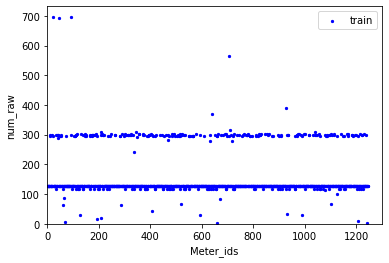

In [14]:
# 전력량 전저리 절차
# 1. 모든 nan -> 0
# 2. 시계열 앞뒤 0인 행은 제거
# 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리 (본인 코드)
# 3.2 전력 사용량 있는 곳 중간의 0은 직전 값으로 처리
# 3.3 전력 사용량 있는 곳 중간의 0은 1주일 전의 평균값으로 처리
# 4. 전력 사용량 24h -> 1d로 합치기
# 5. 1주일 평균값, 1주일 전의 전력량을 feature로 추가
# 진짜 0과 nan->0을 차이를 둘 것인가?

train_2 = train_.copy()
# 1. 모든 nan -> 0
train_2.fillna(0, inplace=True)
columns_ = train_2.columns
meter_ids = columns_[1:]

train_2['Time'] = pd.to_datetime(train_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

start = time.time()
mod = sys.modules[__name__]

num_met = []
num_raw = []

def PreModel(train_2, meter_ids, case):
    count_ = 0
    for meter_id in meter_ids:
        start_idx = 0
        start_sig = 0
        end_idx = 0
        for i in range(len(train_2[meter_id])-1):
            if start_sig == 0 and train_2[meter_id].iloc[i] == 0 and train_2[meter_id].iloc[i+1] != 0:
                start_idx = i+1
                start_sig = 1
            if start_sig == 1 and train_2[meter_id].iloc[i] != 0 and train_2[meter_id].iloc[i+1] == 0:
                end_idx= i
        # 2. 시계열 앞뒤 0인 행 제거
        prepro_ = pd.DataFrame({'date':train_2['Time'].iloc[start_idx:end_idx+1].tolist(), 'power':train_2[meter_id].iloc[start_idx:end_idx+1].tolist()}, columns=['date', 'power'])
        # 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리
        # 0 -> 구간 평균
        for i in range(len(prepro_)):
            if prepro_.loc[i, 'power'] == 0:
                prepro_.loc[i, 'power'] = sum(prepro_.loc[i-7:i, 'power'].values)/7

        # 이상치 부분 추가 가능
        # train_list[count_].append(train_2['Time'].iloc[start_idx:end_idx+1].tolist())
        # train_list[count_].append(train_2[meter_id].iloc[start_idx:end_idx+1].tolist())
        
        # power_d (직전 7d의 평균) feature 추가
        # power_d1, d2, ..., d7 feature 추가
        if case == 1:
            if len(prepro_) > 7:
                # 전력 사용량 24h -> 1d로 합치기
                prepro_['date'] = prepro_['date'].dt.date
                prepro_ = prepro_.groupby('date').mean()
                prepro_['date'] = prepro_.index
                prepro_.reset_index(drop=True, inplace=True)
                
                power_d = []
                power_d1 = []
                power_d2 = []
                power_d3 = []
                power_d4 = []
                power_d5 = []
                power_d6 = []
                power_d7 = []
                calc_d = []
                date_ = []
                for i in range(7):
                    calc_d.append(prepro_['power'].iloc[i])
                mean_d = sum(calc_d)/len(calc_d)
                for i in range(7, len(prepro_)):
                    power_d.append(mean_d)
                    power_d7.append(calc_d[0])
                    power_d6.append(calc_d[1])
                    power_d5.append(calc_d[2])
                    power_d4.append(calc_d[3])
                    power_d3.append(calc_d[4])
                    power_d2.append(calc_d[5])
                    power_d1.append(calc_d[6])
                    calc_d.pop(0)
                    calc_d.append(prepro_['power'].iloc[i])
                    date_.append(prepro_['date'].iloc[i])
                    mean_d = sum(calc_d)/len(calc_d)
                case_1 = pd.DataFrame({'date':date_, 'power_d':power_d, 'power_d7':power_d7, 'power_d6':power_d6, 'power_d5':power_d5, 'power_d4':power_d4, 'power_d3':power_d3, 'power_d2':power_d2, 'power_d1':power_d1}, columns=['date','power_d','power_d7','power_d6','power_d5','power_d4','power_d3','power_d2','power_d1'])
                return_ = pd.merge(case_1, prepro_, on='date', how='left')
                return_.dropna(inplace=True)
                return_.reset_index(drop=True, inplace=True)
                num_raw.append(len(return_))
                num_met.append(count_+1)
                
                final_add = pd.merge(weather_d_final, return_, on='date', how='right')
                if count_ == 0:
                    final_ans = final_add.copy()
                else:
                    final_ans = pd.concat([final_ans, final_add], ignore_index=True)
                    final_ans.reset_index()
                
                count_ += 1
                if count_%100 == 0:
                    print(count_, "세대, 계산 시간 : ", time.time() - start)
    if count_ != 0:
        return final_ans
    
# case 1 : 1주일
# case 2 : 2주일
# case 3 : 3주일
final_ans = PreModel(train_2, meter_ids, 1)
#PreModel(train_2, meter_ids, mod, 2)
#PreModel(train_2, meter_ids, mod, 3)

#print(model_0)
#print(model_1)

plt.scatter(num_met, num_raw, s=5, color='b', label='train')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(bottom=0)
plt.xlabel('Meter_ids')
plt.ylabel('num_raw')
plt.show()

# 추가로 고려해야 하는 변수 : 직전 7d 표준편차


# date analysis

In [93]:
final_ans = pd.read_csv('data/problem_final2.csv', sep=',')
final_ans

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,20170905,22.5,21.4,23.7,0.0,2.016667,63.500000,0.0,2017,9,...,0.0,0.133349,0.117071,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292
1,20170906,20.8,18.7,23.1,1.9,1.533333,82.458333,0.0,2017,9,...,0.0,0.142524,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667
2,20170907,22.2,18.4,25.8,0.0,2.095833,80.083333,0.0,2017,9,...,0.0,0.150292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458
3,20170908,23.6,21.2,27.4,0.0,1.925000,77.833333,0.0,2017,9,...,0.0,0.155845,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000
4,20170909,23.4,20.7,27.1,0.0,2.004167,80.958333,0.0,2017,9,...,0.0,0.158940,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000,0.267958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,20180625,24.7,20.3,29.0,0.0,1.933333,71.833333,0.0,2018,6,...,0.0,0.100674,0.103590,0.066542,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333
61452,20180626,21.3,19.4,24.0,90.3,4.466667,90.166667,0.0,2018,6,...,0.0,0.094637,0.066542,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875
61453,20180627,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.0,0.094685,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875,0.063583
61454,20180628,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.0,0.094661,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875,0.063583,0.064542


In [103]:
for i in range(len(final_ans['date'])):
    final_ans['date'][i] = pd.Timestamp(final_ans['year'][i], final_ans['month'][i], final_ans['day'][i])
final_ans['date']

c:\users\ilifo-028\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0       2017-09-05
1       2017-09-06
2       2017-09-07
3       2017-09-08
4       2017-09-09
           ...    
61451   2018-06-25
61452   2018-06-26
61453   2018-06-27
61454   2018-06-28
61455   2018-06-29
Name: date, Length: 61456, dtype: datetime64[ns]

In [104]:
final_ans['date'] = final_ans['date'].astype('datetime64')
df = pd.DataFrame(final_ans['date'].values)
df.columns = ['date']
df

,date
0,2017-09-05
1,2017-09-06
2,2017-09-07
3,2017-09-08
4,2017-09-09
...,...
61451,2018-06-25
61452,2018-06-26
61453,2018-06-27
61454,2018-06-28


In [133]:
final_ans['date'].sort_values()

36063   2016-08-11
36064   2016-08-12
36065   2016-08-13
36066   2016-08-14
36067   2016-08-15
           ...    
36677   2018-06-29
36955   2018-06-29
35467   2018-06-29
35468   2018-06-30
22085   2018-06-30
Name: date, Length: 61456, dtype: datetime64[ns]

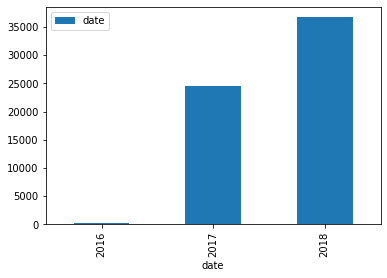

In [105]:
df.groupby(df['date'].dt.year).count().plot(kind='bar')

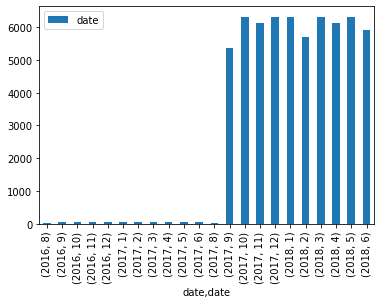

In [106]:
df.groupby([df['date'].dt.year, df['date'].dt.month]).count().plot(kind='bar')

In [78]:
test_2 = test_.copy()
# 1. 모든 nan -> 0
test_2.fillna(0, inplace=True)
columns_ = test_2.columns
meter_ids = columns_[1:]

test_2['Time'] = pd.to_datetime(test_2['Time'], format='%Y.%m.%d %H:%M', errors='raise')

start = time.time()
mod = sys.modules[__name__]

num_met = []
num_raw = []

def PreModel(test_2, meter_ids, case):
    count_ = 0
    for meter_id in meter_ids:
        start_idx = 0
        start_sig = 0
        end_idx = 0
        for i in range(len(test_2[meter_id])-1):
            if start_sig == 0 and test_2[meter_id].iloc[i] == 0 and test_2[meter_id].iloc[i+1] != 0:
                start_idx = i+1
                start_sig = 1
            if start_sig == 1 and test_2[meter_id].iloc[i] != 0 and test_2[meter_id].iloc[i+1] == 0:
                end_idx= i
        # 2. 시계열 앞뒤 0인 행 제거
        prepro_ = pd.DataFrame({'date':test_2['Time'].iloc[start_idx:end_idx+1].tolist(), 'power':test_2[meter_id].iloc[start_idx:end_idx+1].tolist()}, columns=['date', 'power'])
        # 3.1 전력 사용량 있는 곳 중간의 0은 평균값으로 처리
        # 0 -> 구간 평균
        for i in range(len(prepro_)):
            if prepro_.loc[i, 'power'] == 0:
                prepro_.loc[i, 'power'] = sum(prepro_.loc[i-7:i, 'power'].values)/7

        # 이상치 부분 추가 가능
        # train_list[count_].append(train_2['Time'].iloc[start_idx:end_idx+1].tolist())
        # train_list[count_].append(train_2[meter_id].iloc[start_idx:end_idx+1].tolist())
        
        # power_d (직전 7d의 평균) feature 추가
        # power_d1, d2, ..., d7 feature 추가
        if case == 1:
            if len(prepro_) > 7:
                # 전력 사용량 24h -> 1d로 합치기
                prepro_['date'] = prepro_['date'].dt.date
                prepro_ = prepro_.groupby('date').mean()
                prepro_['date'] = prepro_.index
                prepro_.reset_index(drop=True, inplace=True)
                
                power_d = []
                power_d1 = []
                power_d2 = []
                power_d3 = []
                power_d4 = []
                power_d5 = []
                power_d6 = []
                power_d7 = []
                calc_d = []
                date_ = []
                for i in range(7):
                    calc_d.append(prepro_['power'].iloc[i])
                mean_d = sum(calc_d)/len(calc_d)
                for i in range(7, len(prepro_)):
                    power_d.append(mean_d)
                    power_d7.append(calc_d[0])
                    power_d6.append(calc_d[1])
                    power_d5.append(calc_d[2])
                    power_d4.append(calc_d[3])
                    power_d3.append(calc_d[4])
                    power_d2.append(calc_d[5])
                    power_d1.append(calc_d[6])
                    calc_d.pop(0)
                    calc_d.append(prepro_['power'].iloc[i])
                    date_.append(prepro_['date'].iloc[i])
                    mean_d = sum(calc_d)/len(calc_d)
                case_1 = pd.DataFrame({'date':date_, 'power_d':power_d, 'power_d7':power_d7, 'power_d6':power_d6, 'power_d5':power_d5, 'power_d4':power_d4, 'power_d3':power_d3, 'power_d2':power_d2, 'power_d1':power_d1}, columns=['date','power_d','power_d7','power_d6','power_d5','power_d4','power_d3','power_d2','power_d1'])
                return_ = pd.merge(case_1, prepro_, on='date', how='left')
                return_.dropna(inplace=True)
                return_.reset_index(drop=True, inplace=True)
                num_raw.append(len(return_))
                num_met.append(count_+1)
                
                if count_ == 0:
                    final_ans = return_
                else:
                    final_ans = pd.concat([final_ans, return_], ignore_index=True)
                    final_ans.reset_index()
                
                count_ += 1
                if count_%100 == 0:
                    print(count_, "세대, 계산 시간 : ", time.time() - start)
    if count_ != 0:
        return final_ans

final_ans_test = PreModel(test_2, meter_ids, 1)

100 세대, 계산 시간 :  37.49178647994995


In [79]:
final_ans_test

,date,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,2017-09-01,0.602369,0.545042,0.892917,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750
1,2017-09-02,0.575470,0.892917,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375
2,2017-09-03,0.518107,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333
3,2017-09-04,0.563012,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333,0.694042
4,2017-09-05,0.575446,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333,0.694042,0.456292
...,...,...,...,...,...,...,...,...,...,...
45596,2018-06-25,0.441755,0.744627,0.393125,0.342542,0.340542,0.339744,0.503208,0.428500,0.381667
45597,2018-06-26,0.389904,0.393125,0.342542,0.340542,0.339744,0.503208,0.428500,0.381667,0.370125
45598,2018-06-27,0.386618,0.342542,0.340542,0.339744,0.503208,0.428500,0.381667,0.370125,0.307042
45599,2018-06-28,0.381547,0.340542,0.339744,0.503208,0.428500,0.381667,0.370125,0.307042,0.365125


In [107]:
final_ans_test = pd.read_csv('data/problem_final2_test.csv', sep=',')
final_ans_test

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,20170901,22.5,18.2,26.3,0.0,3.108333,62.458333,0.0,2017,9,...,0.0,0.602369,0.545042,0.892917,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750
1,20170902,22.9,19.0,26.9,0.0,2.341667,68.250000,0.0,2017,9,...,0.0,0.575470,0.892917,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375
2,20170903,23.5,20.2,27.0,0.0,2.195833,69.000000,0.0,2017,9,...,0.0,0.518107,0.791000,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333
3,20170904,24.3,20.9,27.9,0.0,1.870833,58.208333,0.0,2017,9,...,0.0,0.563012,0.607000,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333,0.694042
4,20170905,22.5,21.4,23.7,0.0,2.016667,63.500000,0.0,2017,9,...,0.0,0.575446,0.454083,0.399417,0.527125,0.356750,0.491375,1.105333,0.694042,0.456292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45406,20180625,24.7,20.3,29.0,0.0,1.933333,71.833333,0.0,2018,6,...,0.0,0.411842,0.533705,0.393125,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667
45407,20180626,21.3,19.4,24.0,90.3,4.466667,90.166667,0.0,2018,6,...,0.0,0.390122,0.393125,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125
45408,20180627,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.0,0.386836,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042
45409,20180628,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.0,0.381765,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042,0.365125


In [108]:
for i in range(len(final_ans_test['date'])):
    final_ans_test['date'][i] = pd.Timestamp(final_ans_test['year'][i], final_ans_test['month'][i], final_ans_test['day'][i])
final_ans_test['date']

c:\users\ilifo-028\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        2017-09-01 00:00:00
1        2017-09-02 00:00:00
2        2017-09-03 00:00:00
3        2017-09-04 00:00:00
4        2017-09-05 00:00:00
                ...         
45406    2018-06-25 00:00:00
45407    2018-06-26 00:00:00
45408    2018-06-27 00:00:00
45409    2018-06-28 00:00:00
45410    2018-06-29 00:00:00
Name: date, Length: 45411, dtype: object

In [109]:
final_ans_test['date'] = final_ans_test['date'].astype('datetime64')
df_test = pd.DataFrame(final_ans_test['date'].values)
df_test.columns = ['date']
df_test

,date
0,2017-09-01
1,2017-09-02
2,2017-09-03
3,2017-09-04
4,2017-09-05
...,...
45406,2018-06-25
45407,2018-06-26
45408,2018-06-27
45409,2018-06-28


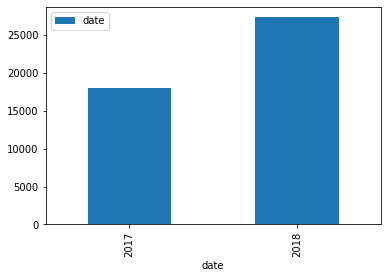

In [112]:
df_test.groupby(df_test['date'].dt.year).count().plot(kind='bar')

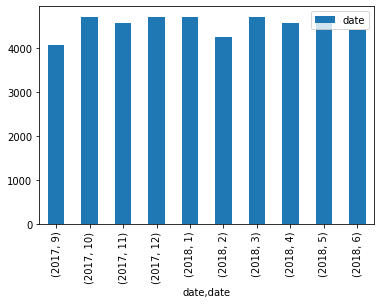

In [113]:
df_test.groupby([df_test['date'].dt.year, df_test['date'].dt.month]).count().plot(kind='bar')

In [114]:
train_

,Time,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,...,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00,0.271,0.754,0.327,0.468,NaN,0.314,0.769,0.790,0.558,...,0.523,0.455,0.295,0.056,0.295,2.089,0.619,1.063,0.345,0.565
16905,2018-06-30 20:00,0.341,0.827,0.478,0.356,NaN,0.434,0.680,0.819,0.470,...,0.350,0.799,0.287,0.057,0.548,2.168,0.723,4.760,0.388,0.620
16906,2018-06-30 21:00,0.535,0.516,0.558,0.496,NaN,0.479,0.590,0.910,0.424,...,0.446,0.754,0.433,0.060,0.677,2.028,0.766,5.386,0.440,0.573
16907,2018-06-30 22:00,0.379,0.494,0.605,0.320,NaN,0.555,0.604,1.044,0.412,...,0.567,0.504,0.384,0.210,1.019,1.055,0.735,7.150,0.393,0.629


In [126]:
train_m = train_.copy()
# 1. 모든 nan -> 0
train_m.fillna(0, inplace=True)

In [129]:
max(train_m['NX665'].values)

810.9910000000001

In [131]:
count = 0
m = []
for i in range(1,1301):
    if max(train_m[f'NX{i}'].values) > 100:
        count += 1
        m.append(i)
print(count, m)

3 [665, 732, 1173]
